In [6]:
using Crystalline, MPBUtils, SymmetryBases, Pkg, MPB_ANALYSIS;
using PyPlot
using Crystalline: label, formatirreplabel, symvec2string

In [1]:
using GLMakie

┌ Info: Precompiling GLMakie [e9467ef8-e4e7-5192-8a1a-b1aee30e663a]
└ @ Base loading.jl:1317


In [7]:
corner_charge_pg16 = MPB_ANALYSIS.corner_charge_pg16
corner_charge_pg2 = MPB_ANALYSIS.corner_charge_pg2
corner_charge_pg10 = MPB_ANALYSIS.corner_charge_pg10

corner_charge_pg10 (generic function with 1 method)

In [8]:
sg = 16
mode = "te"
id = 30
calcname = "dim2-sg$sg-$id-res64-$mode"
bandirsd, lgirsd = extract_individual_multiplicities(calcname,
                        timereversal=true, dir = "./symeigs/output", atol=1e-3);

In [4]:
f = Figure()
#=sgnums = [2, 9:17...]
groupmax = 5
rowmax = 2
colmax = 5
for row in 1:rowmax
    for col in 1:colmax
        i = (row-1)*colmax + col
        ax = Axis(f[2row, (col-1)*groupmax+1:col*groupmax])
        #= plotting with index `i`
        barplot!
        =#
        ax.title[] = "SG "*string(sgnums[i])
        ax.yticks = [Inf,]
        ax.xticks = 1:groupmax
        xlims!(ax, (.5,groupmax+.5))
        for scol in 1:groupmax
            ax = Axis(f[2row-1, (col-1)*groupmax+scol], height=20.4)
            #= plotting
            =#
            ax.yticks = [Inf,]
            ax.xticks = [Inf,]
        end
    end
end=#
f


Figure()

┌ Warning:     GLFW couldn't create an OpenGL window.
│     This likely means, you don't have an OpenGL capable Graphic Card,
│     or you don't have an OpenGL 3.3 capable video driver installed.
│     Have a look at the troubleshooting section in the GLMakie readme:
│     https://github.com/JuliaPlots/Makie.jl/tree/master/GLMakie#troubleshooting-opengl.
└ @ GLMakie /home/gridsan/aligho/.julia/packages/GLMakie/pFGSp/src/screen.jl:336


In [9]:
function return_n(bandirsd::Dict{String, Vector{Pair{UnitRange{Int64}, Vector{Int64}}}},
lgirsd::Dict{String, Vector{LGIrrep{2}}}, bandrange::UnitRange{Int64})
    n = Int64[]
    for (klab, lgirs) in lgirsd
        n_irrep = zeros(length(lgirs))
        for (range, n_pair) in bandirsd[klab]
            maximum(range) > maximum(bandrange) && continue
            minimum(range) < minimum(bandrange) && continue
            n_irrep += n_pair
        end
        n = vcat(n, n_irrep)
    end
    return Int.(n)
end
    
# Instead of this, use collect separable- example file in MPBUtils and pull request 
function return_n_and_irrep(bandirsd::Dict{String, Vector{Pair{UnitRange{Int64}, Vector{Int64}}}},
lgirsd::Dict{String, Vector{LGIrrep{2}}}, bandrange::UnitRange{Int64})
    n = return_n(bandirsd, lgirsd, bandrange)
    irlabs = vcat([label.(lgirs) for (klab, lgirs) in lgirsd]...)
    return n, irlabs
end
    

return_n_and_irrep (generic function with 1 method)

In [10]:
function topology_bandgroupings(id::Integer, polarization::AbstractString, sg::Integer = 2)
    g = label_topologies("dim2-sg$sg-$id-res64-$polarization", true, "./symeigs/output")
    
    topo = Int.(isequal.(TopologyKind(1), [grouping[2] for grouping in g]))
    fragile = Int.(isequal.(TopologyKind(2), [grouping[2] for grouping in g]))
    vcat(topo, zeros(20 - length(topo))),  vcat(fragile, zeros(20 - length(topo)))

end

topology_bandgroupings (generic function with 2 methods)

In [11]:
function topology_bandgroupings_and_corner(id::Integer, polarization::AbstractString, sg::Integer = 2)
    g = label_topologies("dim2-sg$sg-$id-res64-$polarization", true, "./symeigs/output")
    
    topo = Int.(isequal.(TopologyKind(1), [grouping[2] for grouping in g]))
    fragile = Int.(isequal.(TopologyKind(2), [grouping[2] for grouping in g]))
    c = []
    calcname = "dim2-sg$sg-$id-res64-$mode"
    bandirsd, lgirsd = extract_individual_multiplicities(calcname,
                        timereversal=true, dir = "./symeigs/output", atol=1e-3);
    for(range, _) in g
        n, irlabs = return_n_and_irrep(bandirsd, lgirsd, range)
        if sg == 16
            c = vcat(c, corner_charge_pg16(n, irlabs))
        elseif sg == 2
            c = vcat(c, corner_charge_pg2(n, irlabs))
        elseif sg == 10
            c = vcat(c, corner_charge_pg10(n, irlabs))
        else 
            c = zeros(20)
        end
    end
    vcat(topo, zeros(20 - length(topo))),  vcat(fragile, zeros(20 - length(topo))), (!iszero).(vcat(c, zeros(20 - length(c)))), 
    vcat(length.([first(grouping) for grouping in g]), zeros(20 - length(g)))
end

topology_bandgroupings_and_corner (generic function with 2 methods)

In [61]:
topology_bandgroupings_and_corner(163, "te", 14)[4]

20-element Vector{Float64}:
 1.0
 1.0
 2.0
 3.0
 3.0
 2.0
 1.0
 1.0
 3.0
 2.0
 1.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [54]:
g = label_topologies("dim2-sg13-10-res64-te", true, "./symeigs/output")
length.([grouping[1] for grouping in g])
g

11-element Vector{Any}:
 Any[1:1, TRIVIAL]
 Any[2:3, TRIVIAL]
 Any[4:4, TRIVIAL]
 Any[5:5, TRIVIAL]
 Any[6:7, TRIVIAL]
 Any[8:8, TRIVIAL]
 Any[9:9, TRIVIAL]
 Any[10:11, TRIVIAL]
 Any[12:12, TRIVIAL]
 Any[13:17, TRIVIAL]
 Any[18:19, FRAGILE]

In [175]:
MPB_ANALYSIS.corner_charge_pg16(n, irlabs)

5//6

In [12]:
all_topological_te = []
all_fragile_te = []
all_charges_te = []
all_topological_tm = []
all_fragile_tm = []
all_charges_tm = []

all_num_bands_te = []
all_num_bands_tm = []

for sg in (2, 9, 10, 11, 12, 13, 14, 15, 16, 17)
    topological_te = zeros(20)
    fragile_te = zeros(20)
    charges_te = zeros(20)
    topological_tm = zeros(20)
    fragile_tm = zeros(20)
    charges_tm = zeros(20)
    num_bands_te = zeros(20, 20)
    num_bands_tm = zeros(20, 20)

    sg in (2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17) || continue
    println("Calculating spacegroup $sg"); flush(stdout)
    for id in 1:10
        for polarization in ("te", "tm")
            try
                t, f, c, num_bands= topology_bandgroupings_and_corner(id, polarization, sg)
                num_bands = Int.(num_bands)
                if polarization == "te"
                    fragile_te += f
                    topological_te += t
                    charges_te += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_te[i, nband] += 1
                    end
                else
                    fragile_tm += f
                    topological_tm += t
                    charges_tm += c
                    for (i, nband) in enumerate(num_bands)
                        iszero(nband) && continue
                        num_bands_tm[i, nband] += 1
                    end
                end
            catch
            end
        end
    end
    push!(all_num_bands_te, num_bands_te)
    push!(all_num_bands_tm, num_bands_tm)
    push!(all_fragile_te, fragile_te)
    push!(all_topological_te, topological_te)
    push!(all_charges_te, charges_te)
    push!(all_fragile_tm, fragile_tm)
    push!(all_topological_tm, topological_tm)
    push!(all_charges_tm, charges_tm)

    #=for polarization in ("te", "tm")
        println("sg $sg of polarization $polarization $(has_fragile[polarization]) lattices")
        println("sg $sg of polarization $polarization $(has_topological[polarization]) lattices")
        flush(stdout)
end=#
end

Calculating spacegroup 2
Calculating spacegroup 9
Calculating spacegroup 10
Calculating spacegroup 11
Calculating spacegroup 12
Calculating spacegroup 13
Calculating spacegroup 14
Calculating spacegroup 15
Calculating spacegroup 16
Calculating spacegroup 17


In [70]:
all_num_bands_te[3]

20×20 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

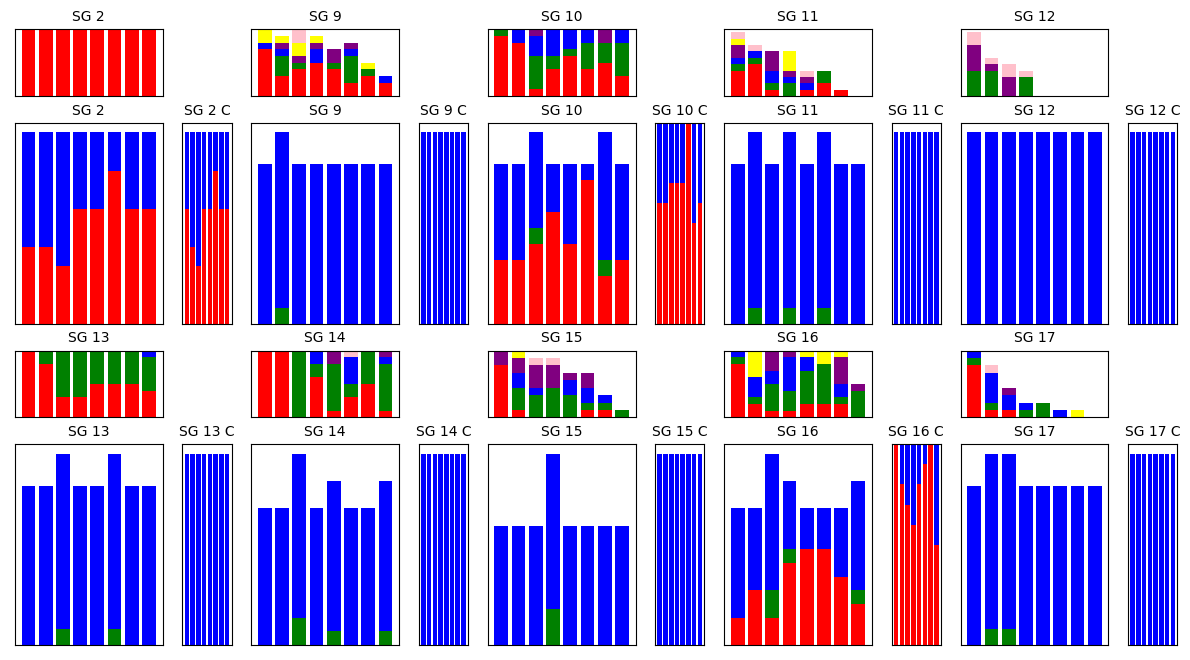

5-element Vector{Nothing}:
 nothing
 nothing
 nothing
 nothing
 nothing

In [158]:
sgs = [2, 9, 10, 11, 12, 13, 14, 15, 16, 17]

band_set_range = 1:8
fig, (axes) = subplots(4, 10, figsize=(15, 8), gridspec_kw=Dict("width_ratios" => [3, 1, 3, 1, 3, 1, 3, 1, 3, 1], "height_ratios" => [1, 3, 1, 3]))
#xlabel("Band Grouping")
ax_num = 1
for (i, sg) in enumerate(sgs)
    row = i > 5 ? 2 : 1
    col = rem(i, 5)
    col = iszero(col) ? 5 : col
    #println("row: $row, col: $col")
    #xticks(1:20)
    axes[2row, 2col-1].set_title("SG $sg", size=10)
    axes[2row, 2col-1].bar(band_set_range, all_topological_te[i][1:8], color="red", label="topological")
    axes[2row, 2col-1].bar(band_set_range, all_fragile_te[i][1:8], bottom = all_topological_te[i][1:8], color="green", label = "fragile")
    axes[2row, 2col-1].bar(band_set_range, 10 .- all_topological_te[i][1:8] .+ all_fragile_te[i][1:8], bottom = all_topological_te[i][1:8] + all_fragile_te[i][1:8], color="blue", label="trivial")
    axes[2row, 2col].set_title("SG $sg C", size=10)
    axes[2row, 2col].bar(band_set_range, all_charges_te[i][1:8], color="red", label="w/ corner charge")
    axes[2row, 2col].bar(band_set_range, 10 .- all_charges_te[i][1:8], bottom = all_charges_te[i][1:8], color="blue", label="w/o corner charge")
    
    
    axes[2row, 2col-1].set_yticks([])
    axes[2row, 2col].set_yticks([])
    axes[2row, 2col-1].set_xticks([])
    axes[2row, 2col].set_xticks([])
    axes[2row-1, 2col-1].set_yticks([])
    axes[2row-1, 2col].set_yticks([])
    axes[2row-1, 2col-1].set_xticks([])
    axes[2row-1, 2col].set_xticks([])
    
    axes[2row-1, 2col-1].set_title("SG $sg", size=10)
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 1], color="red", label="topological")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 2], bottom =  all_num_bands_te[i][1:8, 1], color="green", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 3], bottom =  vec(sum(all_num_bands_te[i][1:8, 1:2], dims=2)), color="blue", label = "fragile")

    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 4], bottom =  vec(sum(all_num_bands_te[i][1:8, 1:3], dims=2)), color="purple", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 5], bottom =  vec(sum(all_num_bands_te[i][1:8, 1:4], dims=2)), color="yellow", label = "fragile")
    axes[2row-1, 2col-1].bar(band_set_range, all_num_bands_te[i][1:8, 6], bottom =  vec(sum(all_num_bands_te[i][1:8, 1:5], dims=2)), color="pink", label = "fragile")

end
delaxes.(axes[1, 2:2:10])
delaxes.(axes[3, 2:2:10])

#legend()


In [161]:
pwd()

"/home2/gridsan/aligho/TopologyPaper"